In [235]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np

from sklearn import linear_model

In [236]:
%run preprocessing.py

In [237]:
#Load in the resampled dataset
df = pd.read_csv('data/processed/hourly_pollutionpatterns.csv').set_index('DATETIME')

pollutants = ["TOC", "TN", "TP", "SS"]
logpollutants = ["logTOC", "logTN", "logTP", "logSS"]
flows = ["Flow", "Bypass"]
rain = ["Rain"]
daily_harmonics = ["sine", "cosine"]
is_weekend = ["is_weekend"]
ones = ["ones"]

#Use the function
df_chunks = adding_remaining_features(df)
fetures_shift = logpollutants + rain
df_chunks = dataProcessing_Chunks(df,fetures_shift,6,6)


In [238]:
df = df_chunks.copy()
df.head()

TOC         TN        TP        SS  \
DATETIME                                                              
2021-01-01 05:00:00+00:00  74.140625  27.367812  3.725312  5.595631   
2021-01-01 06:00:00+00:00  65.923958  26.089219  3.375896  4.491904   
2021-01-01 07:00:00+00:00  63.631250  24.883906  3.672448  4.919996   
2021-01-01 08:00:00+00:00  68.146875  23.861979  3.462083  5.175239   
2021-01-01 09:00:00+00:00  75.268750  23.759896  3.970458  5.554139   

                                  Flow    Bypass  Rain      sine  \
DATETIME                                                           
2021-01-01 05:00:00+00:00   830.066667  0.000008   0.0  0.965926   
2021-01-01 06:00:00+00:00   793.966667  0.000004   0.1  1.000000   
2021-01-01 07:00:00+00:00   866.266667  0.000008   0.3  0.965926   
2021-01-01 08:00:00+00:00  1016.950000  0.000009   0.3  0.866025   
2021-01-01 09:00:00+00:00  1067.333333  0.000000   0.0  0.707107   

                                 cosine  ones  ...   logSS-3   logSS-4  \
DATETIME                                       ...                       
2021-01-01 05:00:00+00:00  2.588190e-01     1  ...  0.368363  0.360678   
2021-01-01 06:00:00+00:00  6.123234e-17     1  ...  0.389106  0.368363   
2021-01-01 07:00:00+00:00 -2.588190e-01     1  ...  0.411289  0.389106   
2021-01-01 08:00:00+00:00 -5.000000e-01     1  ...  0.426022  0.411289   
2021-01-01 09:00:00+00:00 -7.071068e-01     1  ...  0.355143  0.426022   

                            logSS-5   logSS-6  Rain-1  Rain-2  Rain-3  Rain-4  \
DATETIME                                                                        
2021-01-01 05:00:00+00:00  0.327913  0.301936     0.0     0.0     0.0     0.0   
2021-01-01 06:00:00+00:00  0.360678  0.327913     0.0     0.0     0.0     0.0   
2021-01-01 07:00:00+00:00  0.368363  0.360678     0.1     0.0     0.0     0.0   
2021-01-01 08:00:00+00:00  0.389106  0.368363     0.3     0.1     0.0     0.0   
2021-01-01 09:00:00+00:00  0.411289  0.389106     0.3     0.3     0.1     0.0   

                           Rain-5  Rain-6  
DATETIME                                   
2021-01-01 05:00:00+00:00     0.0     0.0  
2021-01-01 06:00:00+00:00     0.0     0.0  
2021-01-01 07:00:00+00:00     0.0     0.0  
2021-01-01 08:00:00+00:00     0.0     0.0  
2021-01-01 09:00:00+00:00     0.0     0.0  

[5 rows x 75 columns]

In [239]:
def get_varnames(steps, variables):
    output = []
    for l in range(*steps):
        if l > 0:
            newcn = lambda x, l: f"{x}+{l}"
        elif l < 0:
            newcn = lambda x, l: f"{x}{l}"
        else:
            newcn = lambda x, l: f"{x}"
        
        output.append([newcn(p, l) for p in variables])
    return [item for sublist in output for item in sublist]

steps = (1, 2)
output = get_varnames(steps, logpollutants)
output

['logTOC+1', 'logTN+1', 'logTP+1', 'logSS+1']

In order to make a linear model that predicts one-step ahead and can forecast 6 hours in advance, we would need forecasted inputs (e.g. rain, flow, bypass). For this reason, since this model is supposed to work as a simple benchmark, I decide to exclude them.

In [253]:
current_pollutants = get_varnames((0, 1), logpollutants)
current_flows = get_varnames((0, 1), flows)

features = current_pollutants #+ current_flows + daily_harmonics + is_weekend
features

['logTOC', 'logTN', 'logTP', 'logSS']

In [254]:
#split the sets
train_range = range(20000)
test_range = range(20000, 26683)

dftest = df.iloc[test_range, :]
dftrain = df.iloc[train_range, :]

X_train = dftrain[features]
y_train = dftrain[output]

X_test = dftest[features]
y_test = dftest[output]

In [255]:
reg = linear_model.LinearRegression()
reg.fit(X=X_train, y=y_train)

LinearRegression()

<Axes: >

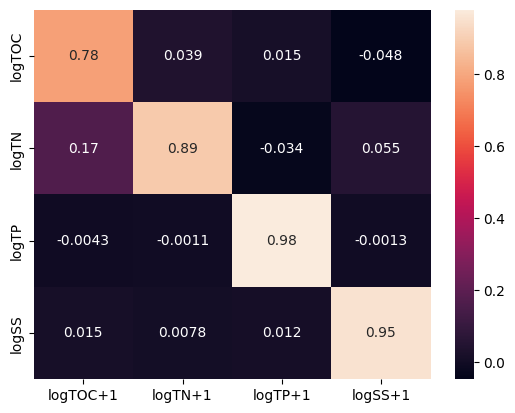

In [256]:
coef_df = pd.DataFrame(reg.coef_.T, columns=output, index=features)
sns.heatmap(coef_df, annot=True)

In [257]:
rmse = lambda x: np.sqrt(np.mean(x**2))
predictions  = reg.predict(X_test)
residuals = reg.predict(X_test) - y_test

for col in residuals:
    print(col, rmse(residuals[col]))

logTOC+1 0.022047726190986366
logTN+1 0.013303342976526722
logTP+1 0.04864752995788494
logSS+1 0.015509897136492506


In [258]:
dfplot = y_test.copy()
dfplot["prediction"] = False

dummy = pd.DataFrame(predictions, columns=output, index=dftest.index)
dummy["prediction"] = True

dfplot = pd.concat([dfplot, dummy], axis=0)
dfplot = pd.melt(dfplot.reset_index(), id_vars=["DATETIME", "prediction"], value_vars=output)

In [259]:
px.line(dfplot, x="DATETIME", y="value", facet_row="variable", color="prediction")

Not a very good model, since it simply shifts the previous value.

### Suggestions

    - We should normalize the data. TP in particular is very skewed and the linear model assumes normally distributed noise.

In [247]:
dfres = pd.DataFrame(residuals, columns=output, index=df.index[test_range])
px.line(dfres)

In [248]:
px.histogram(dfres)

With the VAR model, I can recursively compute the forecast for the next 6 hours.

In [277]:
mp = np.dot

coefs = reg.coef_
steps_ahead = 6

forecasts = []

for i, row in dftest.iterrows():
    current_concentrations = row[pollutants].values
    forecasted_concentrations = []
    for step in range(1, steps_ahead + 1):
        current_concentrations = mp(coefs, current_concentrations)
        forecasted_concentrations.append(current_concentrations)

    forecasts.append(np.array(forecasted_concentrations))

forecasts = np.array(forecasts)
    

In [298]:
columns = [[f"{p}+{l}" for p in pollutants] for l in range(1, 7)]
columns = [item for sublist in columns for item in sublist]

dfcast = pd.DataFrame(np.reshape(forecasts, (forecasts.shape[0], 24)), index=dftest.index, columns=columns)
dfcast


TOC+1       TN+1       TP+1      SS+1  \
DATETIME                                                                
2023-05-17 09:00:00+00:00  143.533795  43.863120   9.471359 -4.677781   
2023-05-17 10:00:00+00:00  151.131605  49.089223  12.039440 -5.018817   
2023-05-17 11:00:00+00:00  156.108747  47.652840  15.896175 -5.578605   
2023-05-17 12:00:00+00:00  154.064431  47.688093  16.657268 -5.969893   
2023-05-17 13:00:00+00:00  115.799311  39.597973  10.427193 -4.234813   
...                               ...        ...        ...       ...   
2024-02-20 06:00:00+00:00   47.654377  13.823150   2.552468 -2.004244   
2024-02-20 07:00:00+00:00   46.787732  14.801953   1.973646 -1.873540   
2024-02-20 08:00:00+00:00   54.896614  17.388594   3.006646 -2.148987   
2024-02-20 09:00:00+00:00   62.104115  22.151635   4.266315 -2.286996   
2024-02-20 10:00:00+00:00   58.036340  23.158082   3.315931 -1.949163   

                                TOC+2       TN+2       TP+2       SS+2  \
DATETIME                                                                 
2023-05-17 09:00:00+00:00  119.284969  44.612642   9.928663  -8.945369   
2023-05-17 10:00:00+00:00  126.069062  49.556733  12.380259  -9.350328   
2023-05-17 11:00:00+00:00  129.695149  48.463609  16.278182 -10.207156   
2023-05-17 12:00:00+00:00  128.094563  48.411201  16.987029 -10.480732   
2023-05-17 13:00:00+00:00   96.913179  39.734024  10.592408  -7.427273   
...                               ...        ...        ...        ...   
2024-02-20 06:00:00+00:00   39.477019  14.150321   2.735689  -3.439789   
2024-02-20 07:00:00+00:00   38.966212  14.989571   2.123545  -3.218842   
2024-02-20 08:00:00+00:00   45.720806  17.605982   3.168665  -3.729521   
2024-02-20 09:00:00+00:00   52.132093  22.125638   4.350062  -3.946137   
2024-02-20 10:00:00+00:00   49.129518  22.866456   3.326480  -3.372026   

                                TOC+3       TN+3  ...       TP+4       SS+4  \
DATETIME                                          ...                         
2023-05-17 09:00:00+00:00  100.396913  44.298772  ...   9.619009 -13.638371   
2023-05-17 10:00:00+00:00  106.498158  48.959629  ...  11.836096 -14.098633   
2023-05-17 11:00:00+00:00  109.120763  48.116964  ...  15.716768 -15.282297   
2023-05-17 12:00:00+00:00  107.854370  48.004824  ...  16.354494 -15.407164   
2023-05-17 13:00:00+00:00   82.131045  39.092207  ...  10.027453 -10.904134   
...                               ...        ...  ...        ...        ...   
2024-02-20 06:00:00+00:00   33.119691  14.110720  ...   2.680679  -5.004720   
2024-02-20 07:00:00+00:00   32.865330  14.840368  ...   2.034517  -4.682597   
2024-02-20 08:00:00+00:00   38.563139  17.428526  ...   3.037545  -5.451341   
2024-02-20 09:00:00+00:00   44.311250  21.699862  ...   4.055142  -5.747222   
2024-02-20 10:00:00+00:00   42.100877  22.247730  ...   2.965732  -4.910650   

                               TOC+5       TN+5       TP+5       SS+5  \
DATETIME                                                                
2023-05-17 09:00:00+00:00  73.742243  41.739236   9.100794 -14.728364   
2023-05-17 10:00:00+00:00  78.763723  45.850014  11.203873 -15.193222   
2023-05-17 11:00:00+00:00  80.086430  45.321703  15.044104 -16.452602   
2023-05-17 12:00:00+00:00  79.264733  45.145468  15.657316 -16.532050   
2023-05-17 13:00:00+00:00  61.102017  36.422698   9.484677 -11.692837   
...                              ...        ...        ...        ...   
2024-02-20 06:00:00+00:00  24.177442  13.360872   2.527340  -5.360334   
2024-02-20 07:00:00+00:00  24.235776  13.933438   1.875048  -5.013732   
2024-02-20 08:00:00+00:00  28.437790  16.360424   2.837581  -5.842072   
2024-02-20 09:00:00+00:00  33.148108  20.142315   3.774067  -6.152526   
2024-02-20 10:00:00+00:00  31.966632  20.450274   2.677870  -5.253720   

                               TOC+6       TN+6       TP+6       SS+6  
DATETIME                                                             